In [1]:
#대한민국 대표 펀드 따라잡기
#K10 인덱스를 추종하는 펀드를 만듦
#지수 수익률을 복제하는 방법 중 대표적인 방법은 1. 지수 구성종목 주식을 그대로 보유 2. 지수 선물을 보유하는 방법 존재, 단 선물로 수익률을 복제하면 파생형 펀드가 되면서 퇴직연금, IRP 같은 안전자산은 이에 투자가 불가능해짐
""" 
<KODEX200, TIGER200을 참고하여 K10 펀드의 투자설명서를 만들면>
투자 목표: 펀드의 순 자산가치 변동률을 KOSPI200 지수의 변동률과 유사하도록 운용
투자 전략: 투자목표를 추구하며 동시에 금융공학 학습의 용이성을 확보하기 위해 KOSPI200 종목에서 시가총액 기준으로 상위 10개 종목을
선정해 투자함으로써 지수 수익률 확보 + 추적오차 현상을 관찰하고 원인파악
포트폴리오 구성: KOSPI200 상위 10개 종목으로 구성된 K10 지수를 산출하고, 펀드 자산 전체를 K10 지수 구성대로 주식을 매입하여 운용
포트폴리오 조정: 2017년 1월 2일부터 2017년 12월 28일까지 1년간만 운용하는 펀드로 별도의 리밸런싱은 없음
"""

#실습의 한계 및 가정
#1. 운용 기간 중 K10의 구성종목은 변하지 않는ㄷ
#2. 운용 기간 중 각 구성종목의 유동주식 수는 변하지 않는다
#3. 운용 보수, 주식 매매 수수료, 증권거래세 등 제반 비용은 고려하지 않는다.
#4. 주식에서 받는 배당은 고려하지 않는다.
#5. 운용 기간 중 이자율은 변하지 않는다.
#6. 최초 설정은 100만 좌로 시작하고, 운용 기간 중 50만 좌 이하로 내려가지 않는다(ETF의 경우 AUM이 50억원 미만이 되면 상장폐지)

#K10 펀드 구성을 위한 사전 준비

import datetime as dt
from urllib.request import urlopen
import bs4
import re
import pandas as pd

"""
2019년 1월 기준 시가총액 상위 10개 종목
005930 삼성전자
000660 SK하이닉스
068270 셀트리온
005380 현대차
207940 삼성바이오로직스
051910 LG화학
005490 POSCO
035420 NAVER
017670 SK텔레콤
015760 한국전력
"""
k10_component = ['005930', '000660', '068270', '005380', '207940', '051910', '005490', '035420', '017670', '015760']

def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    tmp = re.split('/', tmp)
    
    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    
    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id = 'pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [2]:
#발행주식 수, 유동비율, 종목명을 각각 저장할 딕셔너리 선언
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
    stock_info(stock_cd)

In [3]:
#과거 시세만 반영
tmp = {'Outstanding' : k10_outstanding,
       'Floating' : k10_floating,
       'Name': k10_name }
k10_info = pd.DataFrame(tmp)
k10_info

,Outstanding,Floating,Name
005930,5969782550,74.60,삼성전자
000660,728002365,73.39,SK하이닉스
068270,134939385,75.67,셀트리온
005380,213668187,64.41,현대차
207940,66165000,24.74,삼성바이오로직스
051910,70592343,64.29,LG화학
005490,87186835,68.25,POSCO
035420,164263395,75.66,NAVER
017670,80745711,54.75,SK텔레콤
015760,641964077,44.71,한국전력


In [4]:
#구성종목의 일자별 주가를 가져오는 함수를 가져오면
def date_format_html(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_stock_naver_date(stock_cd, start_date='', end_date = '', page_n=1, last_page=0):
    if start_date: #start_date가 있으면
        start_date=date_format_html(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_ = 'tah p10 gray03') #날짜수집
    prices = source.find_all('td', class_='num') #종가수집
    
    for n in range(len(dates)):
        
        if len(dates) >0 :
            this_date = dates[n].text
            this_date = date_format_html(this_date)
        
        if this_date <= end_date and this_date >= start_date:
            this_close = prices[n*6].text
            this_close = this_close.replace(',', '')
            this_close = float(this_close)
            
            #딕셔너리에 저장
            historical_prices[this_date] = this_close
        
        elif this_date < start_date :
            return historical_prices
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find_all('table')[1].find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_stock_naver_date(stock_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices


In [5]:
#K10 종목을 순환하며 2017년 1월1일부터 2017년 12월 13일까지 시세 수집
k10_historical_prices = dict()

for stock_cd in k10_component:
    historical_prices = dict()
    start_date = '2017-1-1'
    end_date = '2017-12-31'
    historical_prices = historical_stock_naver_date(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [26]:
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=0, inplace=True)

In [27]:
#보간
k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_rpcie.fillna(method='bfill')
k10_historical_price.head(3)

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2017-01-02,1805000.0,45800.0,108200.0,150000.0,156500.0,253000.0,260500.0,777000.0,225500.0,43900.0
2017-01-03,1824000.0,47250.0,106600.0,153000.0,158000.0,262000.0,256000.0,767000.0,223000.0,44100.0
2017-01-04,1808000.0,46500.0,106100.0,154000.0,154500.0,268500.0,254500.0,810000.0,223000.0,43900.0


In [28]:
#삼성전자 수정주가 계산
k10_historical_price['005930'] = k10_historical_price['005930'] / 50
k10_historical_price.head(3)

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2017-01-02,36100.0,45800.0,108200.0,150000.0,156500.0,253000.0,260500.0,777000.0,225500.0,43900.0
2017-01-03,36480.0,47250.0,106600.0,153000.0,158000.0,262000.0,256000.0,767000.0,223000.0,44100.0
2017-01-04,36160.0,46500.0,106100.0,154000.0,154500.0,268500.0,254500.0,810000.0,223000.0,43900.0


In [29]:
#수집한 정보를 바탕으로 K10 지수 산출
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.tail(3)

,005930,000660,068270,005380,207940,051910,005490,035420,017670,015760
2017-12-26,2.146567e+14,3.953679e+13,1.991118e+13,2.119405e+13,5.639197e+12,1.779046e+13,2.020195e+13,1.086222e+14,1.228990e+13,1.122257e+13
2017-12-27,2.198227e+14,4.012450e+13,2.246390e+13,2.153811e+13,5.991135e+12,1.790392e+13,1.990443e+13,1.089950e+14,1.182571e+13,1.102165e+13
2017-12-28,2.269482e+14,4.087249e+13,2.257622e+13,2.146929e+13,6.072981e+12,1.838045e+13,1.978542e+13,1.081251e+14,1.180361e+13,1.094989e+13


In [30]:
#시가총액의 합 계산
k10 = pd.DataFrame()
k10['Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,Market Cap
2017-01-02,3.656127e+14
2017-01-03,3.671985e+14
2017-01-04,3.708944e+14


In [31]:
#지수 산출을 위해 기준일을 2017년 1월 2일로 설정
base_date = dt.date(2017,1,2)

In [32]:
#일자별 K10 인덱스 계산
k10['Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * 100
k10.sort_index(axis=0, inplace = True)
k10.head(3)

,Market Cap,Index
2017-01-02,3.656127e+14,100.000000
2017-01-03,3.671985e+14,100.433743
2017-01-04,3.708944e+14,101.444623


In [33]:
#그래프로 그려보면
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
#한글사용 및 그래프 사이즈/모양 세팅
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True


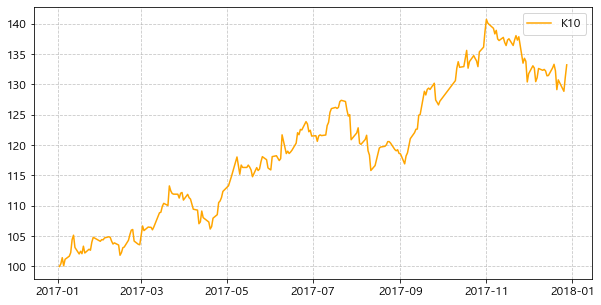

In [35]:
plt.plot(k10['Index'], color = 'orange', label='K10')
plt.legend(loc=0)
plt.grid(True)

In [36]:
#이번에는 K200 지수를 가져오면
def date_format_html(d):
    d = str(d).replace('-', '.') # 날짜가 -로 구분되어있을 경우 .로 바꿈
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    if start_date: #start_date가 있으면
        start_date=date_format_html(start_date)
    else: #없으면
        start_date = dt.date.today() #오늘날짜 지정
    if end_date : #end_date가 있으면
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">태그에서 날짜수집
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">태그에서 지수수집
    
    for n in range(len(dates)): #dates개수만큼 반복
        if dates[n].text.split('.')[0].isdigit():
            #날짜처리
            this_date = dates[n].text
            this_date = date_format_html(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                #종가처리
                this_close=prices[n*4].text
                this_close=this_close.replace(',', '') 
                this_close=float(this_close)
                this_close
    
                #딕셔너리에 저장
                historical_prices_date[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices_date
    
    #페이지 네비게이션
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    #다음페이지 호출
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date

index_cd = 'KPI200'
historical_prices_date = dict()
kospi200 = historical_index_naver_date(index_cd, '2017-1-1', '2017-12-31')
k200 = pd.DataFrame({'Index' : kospi200})
k200.head(3)

,Index
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12


In [38]:
#편하게 비교하기 위해 K10 지수를 KOSPI200과 맞춤
k10['Adj Index'] = k10['Market Cap'] / k10['Market Cap'][base_date] * k200['Index'][base_date]
k10.head(3)

,Market Cap,Index,Adj Index
2017-01-02,3.656127e+14,100.000000,260.360000
2017-01-03,3.671985e+14,100.433743,261.489295
2017-01-04,3.708944e+14,101.444623,264.121222


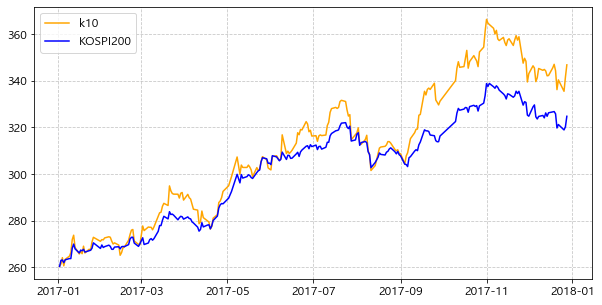

In [39]:
#두 지수의 그래프를 함께 그려보면
plt.plot(k10['Adj Index'], color = 'orange', label = 'k10')
plt.plot(k200['Index'], color = 'blue', label = 'KOSPI200')
plt.legend(loc=0)
plt.grid(True) #KOSPI200보다 K10 수익률이 더 높은 것을 확인

In [40]:
# K10 펀드 설계 및 운용
import numpy as np
# 펀드 기본 정보 설정
CU = 50000 #설정과 환매단위
base_date = dt.date(2017,1,2) #설정 기준일
volume = 1000000 #최초 설정 수량
interest_rate = 0.02 #이자율

In [41]:
# 50만 좌 이상인 경우 환매가 랜덤하게 발생하도록 설정
def creation_redemption(v):
    creation = np.random.randint(0,5) * CU #0 ~ 5 사이의 임의의 정수 x CU
    if v > 500000:
        redemption = np.random.randint(0,5) * CU
    else:
        redemption = 0
    volume = v + creation - redemption # 총 좌수 = 기존 좌수 + 설정 - 환매
    return(creation, redemption, volume)


In [42]:
#보유 비중 산정
k10_stock_ratio = pd.DataFrame()
for s in k10_info.index:
    k10_stock_ratio[s] = k10_historical_mc[s] / k10_historical_mc.sum(axis=1)

In [43]:
#일자별 보유 비중 변동과 설정 및 환매 수량 변동에 따라 펀드의 포트폴리오 변화와 자산가치 변화를 계산
Fund_NAV = pd.DataFrame() #펀드의 순자산가치(NAV)
Fund_Chg = pd.DataFrame() #순자산가치변화

In [68]:
for d in k10_historical_price.index:
    #포트폴리오 구성용 정보(당일 주가, 자산비중)
    stock_price = np.array(k10_historical_price.loc[d])
    stock_weight = np.array(k10_stock_ratio.loc[d])
    
    #기존 주식 포트폴리오 NAV 계산
    if (d<=base_date): #기준일 이전
        #최초 주식 포트폴리오(보유량 0)
        stock_holdings = np.array([0,0,0,0,0,0,0,0,0,0])
        NAV_cash = 0 #최초 현금 보유량
        
    else: #기준일 이후
        NAV_stock = sum(stock_holdings * stock_price) #주식 잔고
        NAV = NAV_stock + NAV_cash #전체 잔고
    
    #기준가격 산정
    if (d <=base_date):
        #최초 기준가를 기준일자의 KOSPI200 지수와 맞춤
        price = k200['Index'][base_date] * 100
    else:
        price = NAV/volume
        
    #신규 펀드 설정 및 환매 좌수 계산
    if (d==base_date):
        volume = 0 #펀드 좌수
        volume_chg = 1000000 #첫날 설정액
    else:
        vol = creation_redemption(volume) #함수 호출
        volume_chg = vol[0] - vol[1] #좌수 변동 , creation_redemption() 함수의 반환값이 creation, redemption, volume이므로 vol[0]은 creation, vol[1]은 redemption을 의미  
    #총 펀드 좌수에 반영
    volume = volume + volume_chg
    aum_chg = price * volume_chg
    
    #신규 주식 거래량 계산
    stock_trade = np.floor(price * volume_chg * stock_weight / stock_price) #floor는 버림
    #주식 매매 금액
    trade_amt = sum(stock_trade * stock_price)
    #현금 잔고 변동
    cash_chg = aum_chg - trade_amt
    
    #총 주식 보유랭 = 기 보유량 + 신규 거래량
    stock_holdings = stock_holdings + stock_trade
    #현금 보유량 증가(이자율 반영)
    cash_holdings = np.floor(NAV_cash * np.exp(interest_rate/365))
    
    #NAV 업데이트
    NAV_stock = sum(stock_holdings * stock_price) #주식 잔고
    NAV_cash = cash_holdings + cash_chg #현금 잔고
    NAV = NAV_stock + NAV_cash #전체 잔고
    
    date = pd.Series(d)

    #Fund NAV 정보를 데이터 프레임에 저장
    NAV_tmp = {'Stock' : NAV_stock, 'Cash': NAV_cash, 'Total': NAV, 'Price' : price}
    tmp = pd.DataFrame(NAV_tmp, index=date)
    Fund_NAV = Fund_NAV.append(tmp)
    
    #일자별 설정 및 환매 좌수 정보를 데이터 프레임에 저장
    Chg_tmp = {'Amount Change' : aum_chg, 'Trade Amount' : trade_amt, 'Cash Change' : cash_chg}
    tmp = pd.DataFrame(Chg_tmp, index=date)
    Fund_Chg = Fund_Chg.append(tmp)

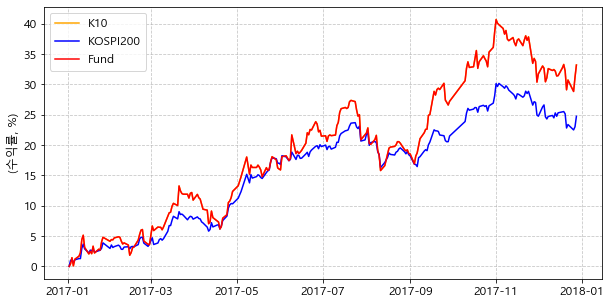

In [71]:
# 펀드 수익률 확인(기준일부터 현재까지의 수익률을 나타내는 YTD(year to date) 수익률 이용)
# 펀드 수익률 vs 지수 수익률
Earnings = pd.DataFrame()
Earnings['K10'] = (k10['Index'] - k10['Index'][base_date]) / k10['Index'][base_date] * 100
Earnings['KOSPI200'] = (k200['Index'] - k200['Index'][base_date]) / k200['Index'][base_date] * 100
Fund_NAV = Fund_NAV.head(243) #위 for문을 돌리면 Fund_NAV에 동일한 값이 계속 append 됨 -> 처음 243개 데이터만 이용
Earnings['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'][base_date]) / Fund_NAV['Price'][base_date] * 100
ax = Earnings.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc = 0)
ax.set_ylabel('(수익률, %)')
ax.grid(True)

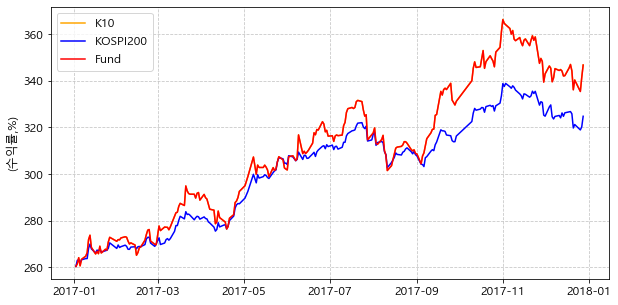

In [72]:
#펀드 기준가 vs 지수
Indicator = pd.DataFrame()
Indicator['K10'] = k10['Adj Index']
Indicator['KOSPI200'] = k200['Index']
Indicator['Fund'] = Fund_NAV['Price']/100
ax = Indicator.plot(color = ['orange', 'blue', 'red'])
ax.legend(loc=0)
ax.set_ylabel('(수익률,%)')
ax.grid(True)

C:\Users\1\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


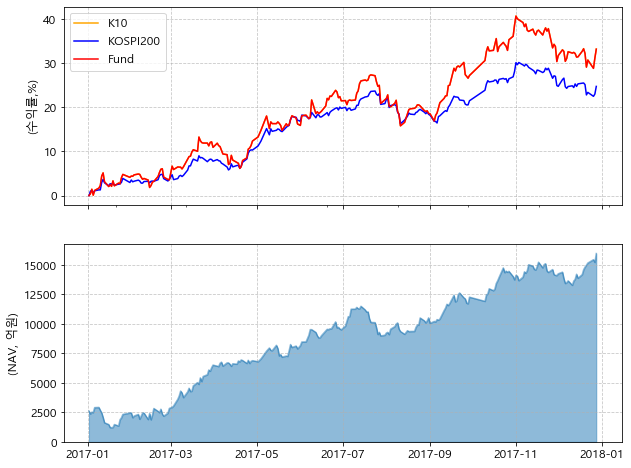

In [74]:
#수익률과 펀드의 NAV 변동을 함께 표시하면
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
Earnings.plot.line(ax=ax1, color = ['orange', 'b', 'r'])
ax1.set_ylabel('(수익률,%)')
Fund_NAV['Display'] = Fund_NAV['Total'] * 0.0000001
Fund_NAV['Display'].plot.area(ax=ax2, stacked = False, sharex=True)
ax2.set_ylabel('(NAV, 억원)')
ax1.grid(True)
ax2.grid(True)

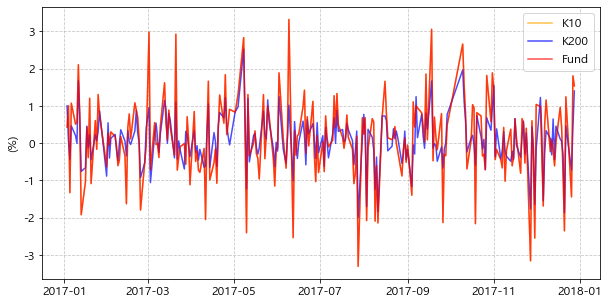

In [76]:
#일간 수익률
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily = pd.DataFrame()
Daily['K10'] = (k10['Index'] - k10['Index'].shift(1))/ k10['Index'].shift(1) * 100 # DataFrame,shift(1)은 전일 날짜의 값, .shift(-1)은 앞의 날짜의 값
Daily['K200'] = (k200['Index'] - k200['Index'].shift(1))/ k200['Index'].shift(1) *100
Daily['Fund'] = (Fund_NAV['Price'] - Fund_NAV['Price'].shift(1))/ Fund_NAV['Price'].shift(1) *100
Daily.plot(ax=ax, color = ['orange', 'b', 'r'], alpha=0.7)
ax.set_ylabel('(%)')
ax.grid(True)

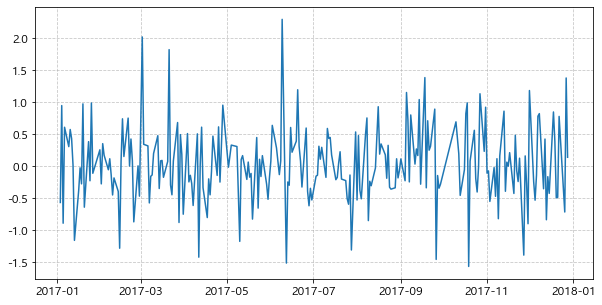

In [77]:
#추적 오차를 구하면
#매일매일의 추적오차는 펀드수익률 - 지수 수익률, 기간별 추적오차는 sqrt(sigma(i=1->n){(펀드수익률 - 지수수익률)^2/(n-1)}) 로 구함
#여기서는 펀드 수익률 - 지수 수익률로 곗ㄴ
#KOSPI200 대비 일간 추적 오차율
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE200'] = Daily['Fund'] -Daily['K200'] 
Daily['TE200'].plot(ax=ax)
ax.grid(True)

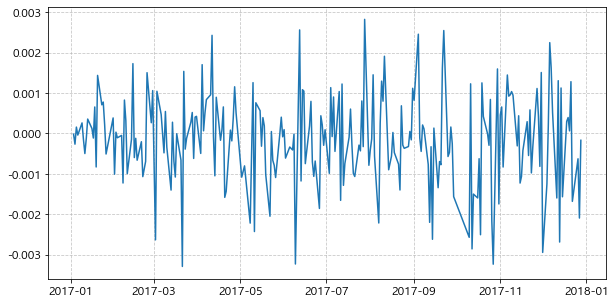

In [78]:
#K10 대비 일간 추적오차율
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Daily['TE10'] = Daily['Fund'] - Daily['K10']
Daily['TE10'].plot(ax=ax)
ax.grid(True)